Tutorial notebook of a basic implementation of VAE. It also emphasis all the assuptions that are made

In [1]:
from typing import List, Optional, Tuple
import numpy as np

from sklearn.preprocessing import MinMaxScaler

from traffic.core import Traffic

import pytorch_lightning as pl
from torch import nn
import torch

from torch.utils.data import DataLoader, random_split

# Data

In [2]:
traffic = Traffic.from_file("../deep_traffic_generation/data/traffic_162-216_noga_tilFAF.pkl")

features = ["track", "groundspeed", "altitude", "timedelta"]
scaler = MinMaxScaler()
X = np.stack(list(f.data[features].values.ravel() for f in traffic))
X = scaler.fit_transform(X)

In [3]:
batch_size = 200
test_batch_size = 100
num_workers = 10


train_dataset, val_dataset, test_dataset = random_split(X, [4000, 207, 207])

train_loader = DataLoader(
        dataset=train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
    )

val_loader = DataLoader(
        dataset=val_dataset,
        batch_size=test_batch_size,
        shuffle=True,
        num_workers=num_workers,
    )

test_loader = DataLoader(
        dataset=test_dataset,
        batch_size=test_batch_size,
        shuffle=True,
        num_workers=num_workers,
    )

# Neural Net

In [4]:
class FCN(nn.Module):
    """Fully-Connected Network.
    Args:
        input_dim: size of each input sample.
        out_dim: size of each output sample.
        h_dims: list of sizes for each hidden layer.
        h_activ (optional): activation function between
            each layer. Defaults to None.
        dropout (optional): if non-zero, introduces a Dropout layer on the
            outputs of each hidden layer except the last layer, with dropout
            probability equal to :attr: `dropout`. Defaults to :math:`0.0`.
    """

    def __init__(
        self,
        input_dim: int,
        out_dim: int,
        h_dims: List[int],
        h_activ: Optional[nn.Module] = None,
        dropout: float = 0.0,
    ) -> None:
        super().__init__()

        layer_dims = [input_dim] + h_dims + [out_dim]
        self.n_layers = len(layer_dims) - 1
        layers = []

        for index in range(self.n_layers):
            layer = nn.Linear(
                in_features=layer_dims[index],
                out_features=layer_dims[index + 1],
            )
            layers.append(layer)
            if (index != self.n_layers - 1) and h_activ is not None:
                layers.append(h_activ)

            if (index != self.n_layers - 1) and (dropout > 0):
                layers.append(nn.Dropout(dropout))

        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        """Forward pass through the network."""
        return self.layers(x)
    

In [5]:
class VAE(pl.LightningModule):
    def __init__(self, input_dim = 800, enc_out_dim=128, latent_dim=32, hidden_dims = [256]):
        super().__init__()

        self.save_hyperparameters()

        # encoder, decoder
        self.encoder = FCN(input_dim, enc_out_dim, hidden_dims, h_activ = nn.Tanh())
        self.decoder = FCN(latent_dim, input_dim, hidden_dims, h_activ = nn.Tanh())

        # latent distributions parameters
        self.fc_mu = nn.Linear(enc_out_dim, latent_dim)
        self.fc_var = nn.Linear(enc_out_dim, latent_dim) #diagonal normal distribution cf. pyro

        # for the gaussian likelihood
        self.log_scale = nn.Parameter(torch.Tensor([0.0]))

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-4)

    #Tout à fait possible de changer la likelyhood ! Gaussienne, Bernoulli, categorical, ....
    #Dans ce cas, on change la famille paramétrique correspondant aux paramètres estimés en sortie de decoder
    def gaussian_likelihood(self, x_hat, logscale, x):
        scale = torch.exp(logscale)
        mean = x_hat
        dist = torch.distributions.Normal(mean, scale)

        # measure prob of seeing image under p(x|z)
        log_pxz = dist.log_prob(x) #taille (n_batch * n_feat)-> on somme sur les dimensions MEAN FIELD ASSUMPTION
        return log_pxz.sum(-1) #une log_prob par couple x,y
    
    #Instead of sampling independently from the marginals, and summing the log_pro, we could directly sample from
    #a multivariate gaussian with diaginal covariance with torch.distributions.Normal(mean, scale).to_event(1)
    
    def kl_divergence(self, z, mu, std):
        # --------------------------
        # Monte carlo KL divergence
        # --------------------------
        # 1. define the first two probabilities (in this case Normal for both)
        p = torch.distributions.Normal(torch.zeros_like(mu), torch.ones_like(std))
        q = torch.distributions.Normal(mu, std)
        #Mean field assumption is done here (1D normals stacked -> marginals)

        # 2. get the probabilities from the equation
        log_qzx = q.log_prob(z) #shape n_batch*latent dim because MFA
        log_pz = p.log_prob(z)

        # kl evaluated for each marginals -> shape n_batch*latent_dims 
        kl = (log_qzx - log_pz)
        #sum over the marginals because of MFA -> shape n_batch (because one distrib per x)
        kl = kl.sum(-1)
        return kl
    
    def forward(self, x) -> Tuple[Tuple, torch.Tensor, torch.Tensor]:
        
        # encode x to get the location and log variance parameters
        x_encoded = self.encoder(x)
        mu, log_var = self.fc_mu(x_encoded), self.fc_var(x_encoded)
        std = torch.exp(log_var / 2)
        q = torch.distributions.Normal(mu, std)
        z = q.rsample() #shape n_batch*latent dims -> one z per distribution (and one distribution per x) 
        
        # decode z
        x_hat = self.decoder(z)
        return (mu, std), z, x_hat

    def training_step(self, batch, batch_idx):
        x = batch.float()

        params, z, x_hat = self.forward(x)

        # reconstruction loss
        recon_loss = self.gaussian_likelihood(x_hat, self.log_scale, x) #shape = n_batch

        # kl estimated with MC
        # Only evaluated with one z per distribution ! Is it the best way ? We could sample different z per distrib
        kl = self.kl_divergence(z, params[0], params[1]) #shape = n_batch 

        # elbo
        elbo = (kl - recon_loss)
        elbo = elbo.mean()

        self.log_dict({
            'elbo': elbo,
            'kl': kl.mean(),
            'recon_loss': recon_loss.mean(),
            'reconstruction': recon_loss.mean(),
            'kl': kl.mean(),
        })

        return elbo

In [6]:
pl.seed_everything(42)

vae = VAE()
trainer = pl.Trainer(gpus=0, max_epochs=100, progress_bar_refresh_rate=1)
trainer.fit(vae, train_loader)

INFO:pytorch_lightning.utilities.seed:Global seed set to 42
INFO:pytorch_lightning.utilities.distributed:GPU available: False, used: False
INFO:pytorch_lightning.utilities.distributed:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.distributed:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.core.lightning:
  | Name    | Type   | Params
-----------------------------------
0 | encoder | FCN    | 237 K 
1 | decoder | FCN    | 214 K 
2 | fc_mu   | Linear | 4.1 K 
3 | fc_var  | Linear | 4.1 K 
-----------------------------------
460 K     Trainable params
0         Non-trainable params
460 K     Total params
1.841     Total estimated model params size (MB)
/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:326: UserWarning: The number of training samples (20) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the tr

Training: -1it [00:00, ?it/s]

In [7]:
x = torch.tensor(X).float()

with torch.no_grad():
    params, z, x_hat = vae.forward(x.to(vae.device))

#Au lieu de tirer z dans la loi à priori, on peut tirer z dans la mixture gaussienne formée par
#toutes les gaussiennes estimées dans l'espace latent
#attention, ici on suppose une fois de plus l'indépendance des marginales dans la GMM (en utilisant distrib.Normal)

#covs = [torch.tensor(np.diag(params[1][i])) for i in range(params[1].shape[0])]
#covs = torch.stack(covs, 0)

mix = torch.distributions.Categorical(torch.ones(x.shape[0],))
comp = torch.distributions.Independent(torch.distributions.Normal(params[0], params[1]), 1)
#comp = torch.distributions.Independent(torch.distributions.MultivariateNormal(params[0], covs), 1)

q = torch.distributions.mixture_same_family.MixtureSameFamily(mix, comp)
z_gen = q.sample((10,))
print(z_gen.shape)

z = z_gen[:1,]
with torch.no_grad():
    pred = vae.decoder(z.to(vae.device)).cpu()

gen = scaler.inverse_transform(pred.numpy())

torch.Size([10, 32])


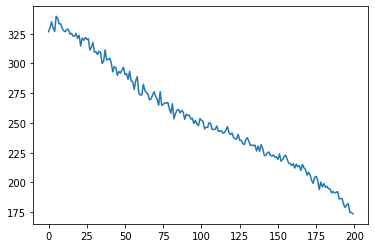

In [8]:
import matplotlib.pyplot as plt
plt.plot(gen[:,1::4].T)
plt.show()

In [9]:
#Generation using a priori distribution
#Dans tous les tutos (towardsdatascience, pyro, etc..), on sample z parmi la distribution à priori pour générer
# Z COMES FROM NORMAL(0, 1)
num_preds = 1
p = torch.distributions.Normal(torch.zeros(32), torch.ones(32))
z = p.rsample((num_preds,))

# SAMPLE mean of output normal distribution
with torch.no_grad():
    pred = vae.decoder(z.to(vae.device)).cpu()

gen = scaler.inverse_transform(pred.numpy())

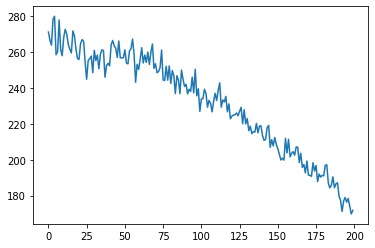

In [10]:
import matplotlib.pyplot as plt
plt.plot(gen[:,1::4].T)
plt.show()

# Use of torch.distribution.Normal

In [11]:
#4 Stacked 1D normal distributions

mu = torch.tensor([0,1,2,3])
std = torch.tensor([1,1,1,1])

p = torch.distributions.Normal(mu, std)
p.log_prob(torch.tensor([0]))

tensor([-0.9189, -1.4189, -2.9189, -5.4189])

In [12]:
#2 Stacked 3D multivariate normal distributions

from torch.distributions.multivariate_normal import MultivariateNormal

mean = torch.Tensor([[0,0,0], [4, 5, 6]])
cov1 = torch.eye(3)
cov2 = torch.Tensor([[1, 1, 1], [1, 2, 2], [1, 2, 3]])
cov = torch.stack([cov1, cov2], 0)
p = MultivariateNormal(loc=mean, covariance_matrix=cov)

p.log_prob(torch.tensor([0,0,0]))

tensor([ -2.7568, -11.7568])

In [13]:
# GMM of 5 bivariate normal distributions
#bizarre, ici on ne passe que les digonales des covariances des normales...
mix = torch.distributions.Categorical(torch.ones(5,))
comp = torch.distributions.Independent(torch.distributions.Normal(torch.randn(5,2), torch.rand(5,2)), 1)
gmm = torch.distributions.mixture_same_family.MixtureSameFamily(mix, comp)

gmm.log_prob(torch.tensor([0,0]))

tensor(-2.4045)